In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

from torch.utils.data import DataLoader, Subset
import sys
sys.path.append("..")

from hsvit.dataset import BrainTumorDataset
from hsvit.model import ViTBackbone
from hsvit.utils import compute_classification_metrics

In [2]:
root_dir = "/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/"
cvind_path = "/Users/darshdave/Documents/BRAINTUMOR/DATASET/cvind.mat"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import mat73
cvinds = mat73.loadmat(cvind_path)['cvind']
test_ids = np.where(np.array(cvinds) == 3)[0]

In [9]:
dataset = BrainTumorDataset(root_dir)
dataset = BrainTumorDataset(root_dir)
test_loader = DataLoader(Subset(dataset, test_ids), batch_size=4, shuffle=False)

In [10]:
model = ViTBackbone().to(device)
state_dict = torch.load("/Users/darshdave/Documents/BRAINTUMOR/HSViT/model-weight/hsvit_best.pt", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()


ViTBackbone(
  (pre_encoder): PreEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 128, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer_blocks): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, e

In [11]:
all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device) - 1

        logits, _, _ = model(images)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


In [ ]:
classes = {0: 'Meningioma', 1: 'Pituitary', 2: 'Glioma'}
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(classes.values())))


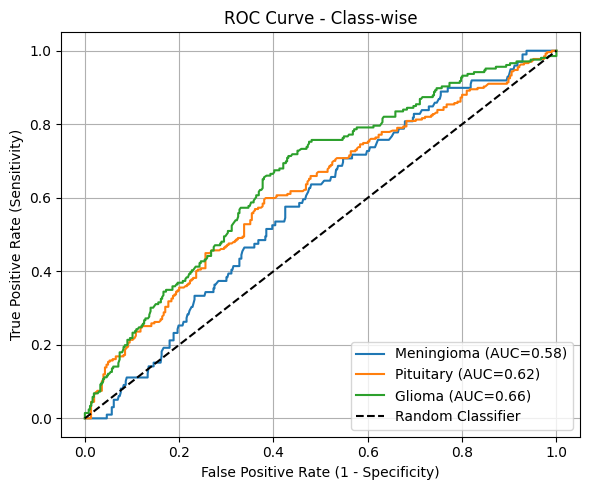

In [20]:
plt.figure(figsize=(6, 5))
for i in range(3):
    binary_true = (np.array(all_labels) == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_true, np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Axis labels
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - Class-wise")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


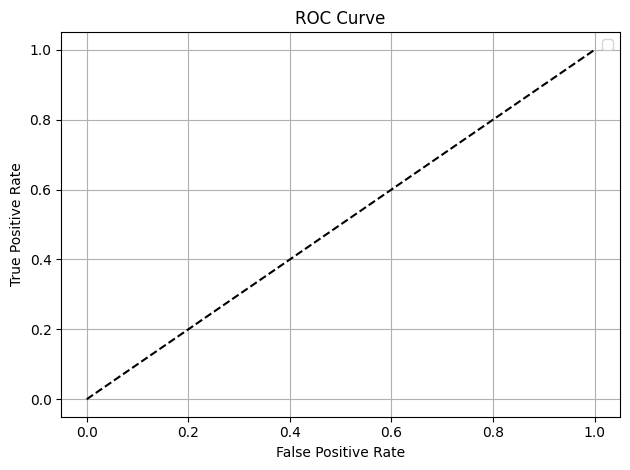

In [15]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
for i in range(3):
    binary_true = (np.array(all_labels) == i).astype(int)
    precision, recall, _ = precision_recall_curve(binary_true, np.array(all_probs)[:, i])
    plt.plot(recall, precision, label=f"{classes[i]}")

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()